# Implement LSTM for Time Series Prediction

What is Time Series Prediction?
Time series prediction refers to the task of forecasting future values based on past observations in a sequential dataset, where each data point is associated with a timestamp. This type of prediction is widely used in various domains such as finance, weather forecasting, sales forecasting, and resource planning.

![image.png](https://machinelearningmastery.com/wp-content/uploads/2016/07/Naive-Time-Series-Prediction-With-Neural-Networks.png)

## Let's import the Dataset

[Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview)

### Store Item Demand Forecasting Challenge
This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting.

In [25]:
import pandas as pd
import numpy as np

In [26]:
train_data = pd.read_csv('/content/data/train.csv')
test_data = pd.read_csv('/content/data/test.csv')

In [27]:
train_data.head()

,date,store,item,sales
0,01-01-2013,1,1,13
1,02-01-2013,1,1,11
2,03-01-2013,1,1,14
3,04-01-2013,1,1,13
4,05-01-2013,1,1,10


In [28]:
train_data.describe

<bound method NDFrame.describe of             date  store  item  sales
0     01-01-2013      1     1     13
1     02-01-2013      1     1     11
2     03-01-2013      1     1     14
3     04-01-2013      1     1     13
4     05-01-2013      1     1     10
...          ...    ...   ...    ...
3994  09-12-2013      3     1     11
3995  10-12-2013      3     1     11
3996  11-12-2013      3     1     14
3997  12-12-2013      3     1     12
3998  13-12-2013      3     1     16

[3999 rows x 4 columns]>

In [29]:
test_data.head()

,id,date,store,item
0,0,01-01-2018,1,1
1,1,02-01-2018,1,1
2,2,03-01-2018,1,1
3,3,04-01-2018,1,1
4,4,05-01-2018,1,1


In [30]:
test_data.describe()

,id,store,item
count,699.000000,699.000000,699.0
mean,349.000000,4.394850,1.0
std,201.928205,2.244069,0.0
min,0.000000,1.000000,1.0
25%,174.500000,2.000000,1.0
50%,349.000000,4.000000,1.0
75%,523.500000,6.000000,1.0
max,698.000000,8.000000,1.0


Group the dataset based on the data (on which date -- amount of sales happened) based on the attributes item, store_number.
After grouping, aggregating the sales column with mean of sales

In [31]:
train_gp = train_data.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,01-01-2013,13.0
1,1,1,01-01-2014,9.0
2,1,1,01-01-2015,11.0
3,1,1,01-01-2016,21.0
4,1,1,01-01-2017,19.0


Now the data is ready.
Now, we need to convert this data to a supervised one, so that we can use it for Time Series Prediction.


In [32]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
window = 29
lag = 90
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,13.0,1.0,1.0,9.0,1.0,1.0,11.0,1.0,...,23.0,1.0,1.0,24.0,1,1,29.0,1.0,1.0,16.0
30,1.0,1.0,9.0,1.0,1.0,11.0,1.0,1.0,21.0,1.0,...,24.0,1.0,1.0,29.0,1,1,23.0,1.0,1.0,14.0
31,1.0,1.0,11.0,1.0,1.0,21.0,1.0,1.0,19.0,1.0,...,29.0,1.0,1.0,23.0,1,1,16.0,1.0,1.0,11.0
32,1.0,1.0,21.0,1.0,1.0,19.0,1.0,1.0,11.0,1.0,...,23.0,1.0,1.0,16.0,1,1,21.0,1.0,1.0,16.0
33,1.0,1.0,19.0,1.0,1.0,11.0,1.0,1.0,13.0,1.0,...,16.0,1.0,1.0,21.0,1,1,42.0,1.0,1.0,12.0


Let's find the input features and output targets

In [34]:
labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

## Split the data into training data and testing data

In [35]:
# Let's import scikit learn packages to split the data into testing and training
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (2328, 92)
Validation set shape (1552, 92)


## Reshape the data compatible to LSTM

In [36]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (2328, 92, 1)
Validation set shape (1552, 92, 1)


# Let's build the model

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is designed to overcome the limitations of traditional RNNs in capturing long-term dependencies in sequential data. It was introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997.

Here's how LSTM works and why it's effective:



*   Memory Cells: The key component of LSTM is its memory cell, which can maintain information over long periods of time. The memory cell is equipped with mechanisms to add or remove information, allowing it to retain relevant information and discard irrelevant information.
*   Gates: LSTM has three gates that regulate the flow of information into and out of the memory cell:


> 1. Forget Gate: Decides what information to discard from the cell state.
2. Input Gate: Decides what new information to store in the cell state
3. Output Gate: Decides what information to output from the cell state.



*    Activation Functions: LSTM uses different activation functions, such as the sigmoid function and the hyperbolic tangent (tanh) function, to control the flow of information through the gates and the memory cell.
*   Backpropagation Through Time (BPTT): LSTM is trained using the backpropagation algorithm, which propagates errors back through time. This allows the network to learn from sequential data and update its parameters to improve prediction accuracy.

Applications: LSTM is widely used in various sequential data tasks, including time series prediction, natural language processing (NLP), speech recognition, and handwriting recognition. Its ability to capture long-term dependencies makes it particularly effective for tasks where context over long sequences is crucial. <br>

![image.png](https://miro.medium.com/v2/resize:fit:1156/1*laH0_xXEkFE0lKJu54gkFQ.png)




    
        

   

    

  

Import the necessary libraries

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model
!pip install visualkeras
import visualkeras

## Function to build the Model

The Model built is shown below <br>

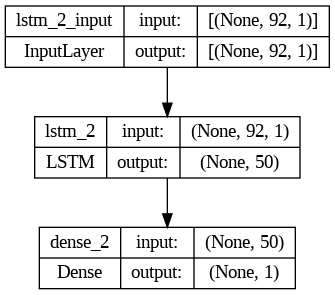

In [38]:
def LSTM_Model(X_train):
  model = Sequential()
  model.add(LSTM(50, input_shape = (X_train.shape[1],X_train.shape[2])))
  model.add(Dense(1,activation = 'linear'))
  model.compile(loss="mean_absolute_error",optimizer = "adam")
  return model

Let's train the model and fit the training data

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


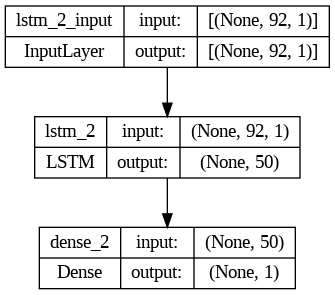

In [39]:
model = LSTM_Model(X_train_series)
model.fit(X_train, Y_train, epochs = 10, verbose = 20,batch_size = 32)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## Evaluate the Model using Evaluation Metrics

In [44]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.metrics import MeanRelativeError, RootMeanSquaredError
train_evaluate = model.evaluate(X_train, Y_train, batch_size=32)
test_evaluate = model.evaluate(X_valid, Y_valid, batch_size=32)

49/49 [==============================] - 1s 21ms/step - loss: 6.5846


In [46]:
prediction = model.predict(X_valid)

49/49 [==============================] - 1s 20ms/step


In [51]:
print("\t \t \t XGBoost Regressor Evaluation Metrics \n \n")
print(f' \t \t Mean Absolute Error (MAE) --: {mean_absolute_error(Y_valid,prediction)}')
print(f'\t \t Mean Squared Error (MSE) --: {mean_squared_error(Y_valid,prediction)}')
print(f'\t \t Mean absolute percentage error (MAPE) --: {mean_absolute_percentage_error(Y_valid,prediction)}')

mre = MeanRelativeError(normalizer = Y_valid)
mre.update_state(Y_valid,prediction)
print(f'\t \t Mean Relative Error (MRE) --: {mre.result().numpy()}')

mse = RootMeanSquaredError()
mse.update_state(Y_valid,prediction)
print(f'\t \t Root Mean Squared Error (RMSE) --: {mse.result().numpy()}')

	 	 	 XGBoost Regressor Evaluation Metrics 
 

 	 	 Mean Absolute Error (MAE) --: 6.584607491788176
	 	 Mean Squared Error (MSE) --: 70.4199337487604
	 	 Mean absolute percentage error (MAPE) --: 0.33695586251886056
	 	 Mean Relative Error (MRE) --: 0.33695587515830994
	 	 Root Mean Squared Error (RMSE) --: 8.391658782958984
